In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news-detection/data.h5
/kaggle/input/fake-news-detection/data.csv


In [2]:
def precision(actual, predicted):
    # Precision = True pos out of the actual results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FP = np.count_nonzero(np.logical_and((actual == 0) , (predicted == 1)).astype(int))
    return TP/(TP + FP)

def recall(actual, predicted):
    # Recall = True pos out of the predicted results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FN = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 0)).astype(int))
    return TP/(TP + FN)

def f_score(actual , predicted):
    P = precision(actual, predicted)
    R = recall(actual, predicted)
    return 2*P*R/(P + R)

def textPreprocess(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text

In [3]:
dataFrame=pd.read_csv('../input/fake-news-detection/data.csv')

dataFrame.dropna()
dataFrame.reset_index(inplace=True)
dataFrame = shuffle(dataFrame,random_state=20)

dataFrame.head(10)

,index,URLs,Headline,Body,Label
2992,2992,https://www.reuters.com/article/us-brazil-corr...,Brazil Olympic committee chief resigns amid br...,FILE PHOTO: President of Brazil's Olympic Comm...,1
2476,2476,https://www.reuters.com/article/us-usa-trump-e...,Eminem rebukes 'racist' Donald Trump in awards...,(Reuters) - Rapper Eminem derided U.S. Preside...,1
1515,1515,http://beforeitsnews.com/u-s-politics/2017/09/...,Racist Teacher To Student: 'Go Back Where You ...,Racist Teacher To Student: 'Go Back Where You ...,0
1389,1389,http://www.cnn.com/2017/10/11/us/california-fi...,California fires: At least 23 dead as hundreds...,"(CNN) In some areas in Sonoma County, the wild...",1
1402,1402,http://beforeitsnews.com/u-s-politics/2017/10/...,"After Alleged 'Moron' Remark, Tillerson Stroke...","Vietnam Is in Great Danger, You Must Publish a...",0
2245,2245,http://beforeitsnews.com/u-s-politics/2017/10/...,King Salman’s Favorite Golden Escalator Betray...,A Potato Battery Can Light up a Room for Over ...,0
3247,3247,https://www.nytimes.com/2017/10/07/world/europ...,"Amid Catalan Crisis, Thousands Hold Rallies in...","The vote, which had been declared illegal by t...",1
1615,1615,https://www.activistpost.com/2017/09/false-arr...,35 False Matches and 1 Erroneous Arrest As Pol...,By Nicholas West\nAll things biometric are swe...,0
2312,2312,http://beforeitsnews.com/sports/2017/09/bucs-f...,Bucs Finish Up Homestand on Winning Note 5-3,Bucs Finish Up Homestand on Winning Note 5-3\n...,0
993,993,http://beforeitsnews.com/sports/2017/09/alex-c...,Alex Collins Worth a Start?,Alex Collins Worth a Start?\n% of readers thin...,0


In [4]:
value_counts = dataFrame['Label'].value_counts()
ratio = value_counts.get(1, 0) / value_counts.get(0, 0)
print("\nFake:Real News ratio is", ratio)
dataFrame['Label'].value_counts()


Fake:Real News ratio is 0.8759943846513805


Label
0    2137
1    1872
Name: count, dtype: int64

In [5]:
stemmer = PorterStemmer()
textList = []
preprocessedText = dataFrame['Body'].apply(textPreprocess)

for text in preprocessedText:
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    textList.append(text)

# Example of the preprocessed text
print(textList[1])

reuter rapper eminem derid u presid donald trump racist reckless leader rap video air tuesday night black entertain televis hip hop award eminem told fan four minut unaccompani vocal must choos whether support presid racism thing fantast eminem rap video tape friday detroit park garag trump previous dismiss accus racism exampl said februari least racist person file photo rapper eminem perform afraid bet award lo angel june reuter mario anzuoni file photo repres white hous immedi respond request comment eminem rap one watch video youtub earli wednesday rap also mention barack obama trump predecessor white hous hillari clinton trump democrat rival last year presidenti elect file photo u rapper eminem perform abu dhabi f grand prix race close concert du arena ya island novemb reuter jumana elheloueh file photo better give obama prop caus got offic kamikaz probabl caus nuclear holocaust eminem rap eminem rebuk trump strong critic nation footbal leagu player kneel nation anthem game gestur 

In [6]:
X=dataFrame.drop('Label',axis=1)
y=dataFrame['Label']

vector=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=vector.fit_transform(textList).toarray()

print(X.shape)

(4009, 5000)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#up-sampling minority classes while avoiding overfitting by generating new synthetic examples close to the minority class in feature space.
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [8]:
features = vector.get_feature_names_out()[:50]
print(features)
count = pd.DataFrame(X_train, columns=vector.get_feature_names_out())
count.head()

['aaron' 'aaron judg' 'aaron kesel' 'aaron rodger' 'ab' 'abandon' 'abc'
 'abc news' 'abe' 'aberti' 'abil' 'abl' 'abort' 'abroad' 'absenc'
 'absolut' 'abus' 'ac' 'academ' 'academi' 'acc' 'acc network' 'accept'
 'access' 'accid' 'accompani' 'accomplish' 'accord' 'accord report'
 'account' 'account allsportsdacc' 'account allsportsdacc pleas' 'accur'
 'accus' 'ace' 'achiev' 'acknowledg' 'acquir' 'acquisit' 'acr' 'across'
 'across countri' 'act' 'action' 'activ' 'activist' 'activist post'
 'activistpost' 'activistpost com' 'actor']


,aaron,aaron judg,aaron kesel,aaron rodger,ab,abandon,abc,abc news,abe,aberti,...,yorker,young,younger,youth,youtub,zach,zapatista,zealand,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.07461,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.048286,0.503343,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.026363,0.0,0.0,0.0,0.0,0.0


In [9]:
# Base models
model1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators=100, random_state=42)

In [10]:
# Max voting ensemble with soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', model1),
        ('nb', model2),
        ('rf', model3)
    ],
    voting='soft'
)

ensemble_model.fit(X_train_resampled, y_train_resampled)
y_pred = ensemble_model.predict(X_test)

Accuracy: 0.98
F-score: 0.98
Precision: 0.97
Recall: 0.99


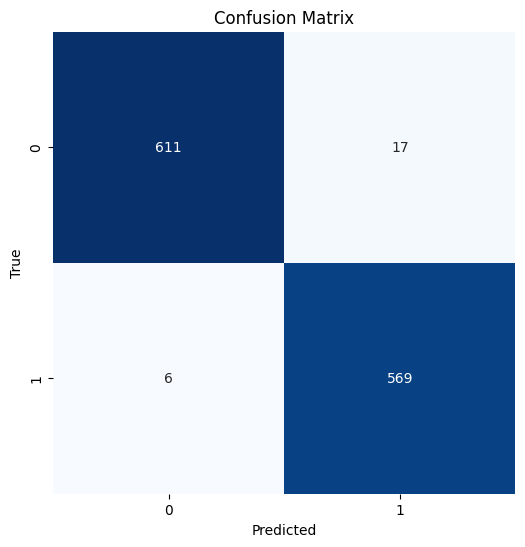

In [11]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
fscore = f_score(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 
print(f'Precision: {prec:.2f}') 
print(f'Recall: {rec:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Base models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [13]:
# Max voting ensemble with soft voting
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('gb', gb_model)
    ],
    voting='soft'
)

ensemble_model.fit(X_train_resampled, y_train_resampled)
y_pred2 = ensemble_model.predict(X_test)

Accuracy: 0.99
F-score: 0.99
Precision: 0.99
Recall: 0.99


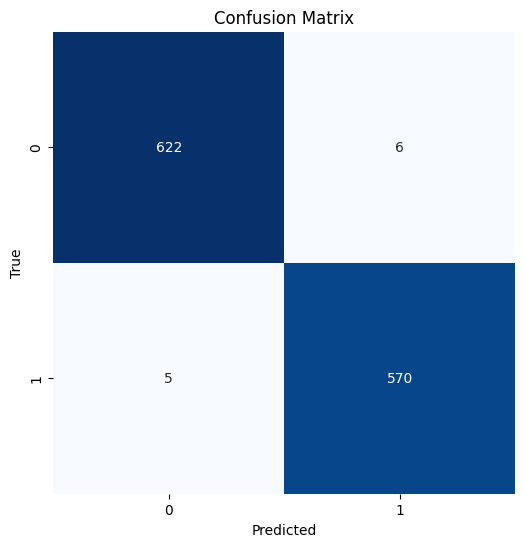

In [14]:
#Evaluation metrics
accuracy = accuracy_score(y_test, y_pred2)
fscore = f_score(y_test, y_pred2)
prec = precision(y_test, y_pred2)
rec = recall(y_test, y_pred2)
conf_m = confusion_matrix(y_test, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}') 
print(f'Precision: {prec:.2f}') 
print(f'Recall: {rec:.2f}') 

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()